<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Mohammad Bagher Soltani, Masih Najafi
### Student Number : 98105813, ?
___

# Introduction

In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.

In [362]:
# imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Data Documentation

For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data. 
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "_mut" at the end of the names of the columns) 
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

# Data Preparation (15 Points)

In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)

## Data Loading & Splitting

In [363]:
# TODO
df = pd.read_csv('METABRIC_RNA_Mutation.csv', low_memory=False)
df.head(5)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [364]:
# Get column names for clinical, gene expression and gene mutation datasets

columns = df.columns
clinical_columns = columns[:31]
clinical_data_columns = df.columns[:24].append(df.columns[25:30])
label_column = columns[24]
gene_columns = columns[31:]
gene_mut_columns = pd.Index(filter(lambda s: s.endswith('_mut'),columns))
gene_expr_columns = pd.Index(set(gene_columns) - set(gene_mut_columns))

print(f'Number of clinical columns {len(clinical_columns)}')
print(f'Number of gene expression columns {len(gene_expr_columns)}')
print(f'Number of gene mutation columns {len(gene_mut_columns)}')

Number of clinical columns 31
Number of gene expression columns 489
Number of gene mutation columns 173


In [365]:
clinical_dataset = df[clinical_columns]
gene_expr_dataset = df[gene_expr_columns]
gene_mut_dataset = df[gene_mut_columns]

## EDA

For each dataset, you must perform a sufficient EDA.

In [366]:
clinical_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

In [367]:
clinical_dataset.describe()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
count,1904.000000,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,1904.000000,1904.000000,1884.000000,1403.000000
mean,3921.982143,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,0.420693,0.597164,26.238726,1.750535
std,2358.478332,12.978711,0.405971,1.228615,0.650612,0.486343,4.079993,4.058778,1.144492,76.334148,0.493800,0.490597,15.160976,0.628999
min,0.000000,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,896.500000,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,0.000000,0.000000,17.000000,1.000000
50%,4730.500000,61.770000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,4.042000,115.616667,0.000000,1.000000,23.000000,2.000000
75%,5536.250000,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,1.000000,1.000000,30.000000,2.000000
max,7299.000000,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,1.000000,182.000000,4.000000


In [368]:
gene_expr_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 489 entries, kmt2c to casp3
dtypes: float64(489)
memory usage: 7.1 MB


In [369]:
gene_expr_dataset.describe()

,kmt2c,abcc1,stat5b,itgb3,npnt,smad5,dtx3,zfp36l1,e2f4,nrip1,...,dtx2,hsd3b2,mtor,nf2,gdf11,twist1,wwox,rad50,hsd17b3,casp3
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,...,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03
mean,-3.151261e-07,-5.252101e-08,-2.100840e-07,-6.827731e-07,0.000001,-8.403361e-07,5.252101e-07,-4.726891e-07,-0.000001,1.575630e-07,...,-0.000001,1.050420e-07,-6.302521e-07,-2.626050e-07,-5.252101e-08,5.777311e-07,5.777311e-07,-8.928571e-07,-1.575630e-07,7.352941e-07
std,1.000262e+00,1.000263e+00,1.000262e+00,1.000263e+00,1.000262,1.000262e+00,1.000262e+00,1.000263e+00,1.000263,1.000263e+00,...,1.000262,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263e+00,1.000263e+00,1.000264e+00,1.000262e+00
min,-2.053300e+00,-2.401000e+00,-2.860600e+00,-3.963500e+00,-2.121900,-1.851200e+00,-3.115500e+00,-3.210900e+00,-2.719400,-3.527000e+00,...,-4.502600,-3.820900e+00,-3.760900e+00,-3.978100e+00,-2.846200e+00,-2.142900e+00,-1.738500e+00,-3.385400e+00,-2.795900e+00,-3.636100e+00
25%,-7.178500e-01,-6.486500e-01,-6.779250e-01,-5.610500e-01,-0.806875,-5.345000e-01,-6.363250e-01,-6.781000e-01,-0.749075,-6.198000e-01,...,-0.683300,-6.573000e-01,-6.554750e-01,-6.945000e-01,-6.518500e-01,-6.500500e-01,-6.400250e-01,-6.480250e-01,-6.467500e-01,-6.543250e-01
50%,-1.562000e-01,-7.965000e-02,-1.510000e-02,-7.745000e-02,-0.025150,-1.590000e-01,-1.000000e-03,2.820000e-02,-0.047050,-2.525000e-02,...,-0.097000,-1.145000e-02,3.540000e-02,-4.270000e-02,-1.695000e-01,-1.573000e-01,-2.693500e-01,-3.950000e-03,-5.270000e-02,-3.830000e-02
75%,5.173500e-01,5.417750e-01,6.660500e-01,4.383250e-01,0.707550,3.118500e-01,6.028000e-01,6.956000e-01,0.672625,6.384000e-01,...,0.555800,6.380750e-01,6.543000e-01,6.290250e-01,4.389000e-01,4.648500e-01,2.789000e-01,6.490500e-01,4.931250e-01,6.230000e-01
max,4.677000e+00,5.347300e+00,4.304200e+00,1.533080e+01,4.022300,1.035490e+01,1.052530e+01,2.816000e+00,4.072000,3.200600e+00,...,4.039700,8.560800e+00,5.293000e+00,4.448400e+00,5.457000e+00,7.939100e+00,5.636800e+00,5.166800e+00,8.292400e+00,6.023900e+00


In [370]:
gene_mut_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 173 entries, pik3ca_mut to siah1_mut
dtypes: object(173)
memory usage: 2.5+ MB


In [371]:
gene_mut_dataset.describe()

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
count,1904,1904,1904,1904,1904,1904,1904,1904,1904,1904,...,1904,1904,1904,1904,1904,1904,1904,1904,1904,1904
unique,160,343,298,248,222,200,128,194,153,154,...,5,5,5,4,4,3,3,3,3,2
top,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
freq,1109,1245,1578,1593,1670,1672,1674,1706,1728,1729,...,1900,1900,1900,1901,1901,1902,1902,1902,1902,1903


In [372]:
# clean data means data with no NaN value in any column
def clean_stats(ds):
    return '''clean data: {0}'''.format(ds.shape[0] - ds.isnull().any(axis=1).sum())

print(f'Clinical dataset {clean_stats(clinical_dataset)}')
print(f'Gene expression dataset {clean_stats(gene_expr_dataset)}')
print(f'Gene mutation dataset {clean_stats(gene_mut_dataset)}')

Clinical dataset clean data: 1092
Gene expression dataset clean data: 1904
Gene mutation dataset clean data: 1904


In [373]:
def dtype_stats(ds):
    return '''
    columns: {0}, object columns: {1}, int columns: {2}, float columns: {3}
    '''.format(len(ds.columns),
               (ds.dtypes == object).sum(),
               (ds.dtypes == int).sum(),
               (ds.dtypes == float).sum())

print(f'Clinical dataset: {dtype_stats(clinical_dataset)}')
print(f'Gene expression dataset: {dtype_stats(gene_expr_dataset)}')
print(f'Gene mutation dataset: {dtype_stats(gene_mut_dataset)}')

Clinical dataset: 
    columns: 31, object columns: 17, int columns: 5, float columns: 9
    
Gene expression dataset: 
    columns: 489, object columns: 0, int columns: 0, float columns: 489
    
Gene mutation dataset: 
    columns: 173, object columns: 173, int columns: 0, float columns: 0
    


In [374]:
# check if int data needs scaling
clinical_dataset[clinical_columns[clinical_dataset.dtypes == int]].head(5)

,patient_id,chemotherapy,hormone_therapy,overall_survival,radio_therapy
0,0,0,1,1,1
1,2,0,1,1,1
2,5,1,1,0,0
3,6,1,1,1,1
4,8,1,1,0,1


In [375]:
# Perform scaling for float data
def scale(scaler, dataset):
    scaled = scaler.fit_transform(dataset)
    scaled_df = pd.DataFrame(scaled)
    scaled_df.columns = dataset.columns
    scaled_df.index = dataset.index
    return scaled_df

scaler = StandardScaler()
clinical_float_columns = list(clinical_columns[clinical_dataset.dtypes == float])
scaled_clinical = scaler.fit_transform(clinical_dataset[clinical_float_columns])
for i, index in enumerate(clinical_dataset.index):
    for j, column in enumerate(clinical_float_columns):
        clinical_dataset.loc[index, column] = scaled_clinical[i, j]

scaled = scaler.fit_transform(gene_expr_dataset)
scaled_df = pd.DataFrame(scaled)
scaled_df.columns = gene_expr_dataset.columns
scaled_df.index = gene_expr_dataset.index
gene_expr_dataset = scaled_df

In [376]:
clinical_dataset.head(5)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,1.122359,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,-1.338368,Positve,...,1.757557,IDC,0.201518,1,Negative,1,ER-/HER2-,-0.279656,0.396748,Living
1,2,-1.379317,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,-1.338368,Positve,...,-0.011378,IDC,-0.530544,1,Positive,1,ER+/HER2- High Prolif,-1.071371,-1.193646,Living
2,5,-0.941562,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,-1.338368,Positve,...,-0.002638,IDC,0.505525,0,Positive,0,NaN,-0.741490,0.396748,Died of Disease
3,6,-1.033275,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,-1.338368,Positve,...,0.014841,MDLC,0.521686,1,Positive,1,NaN,-0.081727,0.396748,Living
4,8,1.224091,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,-1.338368,Positve,...,1.789021,MDLC,-1.097499,0,Positive,1,ER+/HER2- High Prolif,0.907918,0.396748,Died of Disease


In [377]:
gene_expr_dataset.head(5)

,kmt2c,abcc1,stat5b,itgb3,npnt,smad5,dtx3,zfp36l1,e2f4,nrip1,...,dtx2,hsd3b2,mtor,nf2,gdf11,twist1,wwox,rad50,hsd17b3,casp3
0,-0.904500,-1.0213,2.577302,-0.230399,-1.154102,-0.364699,0.602800,0.349200,0.199201,0.4076,...,-1.899400,0.734500,-0.546899,-0.5124,-0.6499,2.809601,-0.446400,1.733000,1.085999,-2.125702
1,-0.020800,0.4261,-1.325101,0.257701,1.112599,-0.539899,-0.799101,1.496300,1.001101,-0.1878,...,-0.177499,0.643300,-0.318599,-0.8002,0.0169,-0.227301,-0.828600,0.744000,0.062300,0.577500
2,-0.506300,-0.5168,-1.083201,0.646901,0.489299,3.486902,-1.290601,2.815999,-0.833299,-0.2882,...,0.231201,-0.912801,-1.747199,0.6707,-1.2771,0.198400,-0.317100,1.452800,0.149300,-0.929101
3,-1.284001,-1.4145,-0.019500,-0.850199,0.602799,7.342503,-1.184501,2.071400,-0.833299,-0.2049,...,-0.276499,1.875401,-1.926499,-0.4457,-0.9396,0.193200,-0.458400,1.210200,0.254600,0.520699
4,-1.102600,-0.8794,-0.427800,-0.319399,-0.569501,-0.718699,-2.401801,-0.091199,-0.318099,0.2832,...,-0.752499,-0.126000,-0.614899,0.8564,-0.3794,0.412800,0.163799,-0.763099,-0.762699,-0.520701


In [378]:
# Convert categorical data to numerical data for clinical dataset
ordinal_encoder = OrdinalEncoder()
encoded = ordinal_encoder.fit_transform(clinical_dataset)
encoded_df = pd.DataFrame(encoded)
encoded_df.columns = clinical_dataset.columns
encoded_df.index = clinical_dataset.index
clinical_dataset = encoded_df

print(f'Clinical dataset {dtype_stats(clinical_dataset)}')

Clinical dataset 
    columns: 31, object columns: 0, int columns: 0, float columns: 31
    


In [379]:
# Perform data imputation for clinical dataset
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data = imputer.fit_transform(clinical_dataset)
imputed_df = pd.DataFrame(imputed_data)
imputed_df.columns = clinical_dataset.columns
imputed_df.index = clinical_dataset.index
clinical_dataset = imputed_df

print(f'Imputed clinical dataset: {clean_stats(clinical_dataset)}')

Imputed clinical dataset: clean data: 1904


In [380]:
clinical_dataset.head(5)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0.0,1341.0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,...,268.0,1.0,998.0,1.0,0.0,1.0,2.0,46.0,2.0,2.0
1,1.0,173.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,...,126.0,1.0,585.0,1.0,1.0,1.0,0.0,11.0,1.0,2.0
2,2.0,328.0,1.0,0.0,1.0,0.0,1.0,3.0,0.0,1.0,...,134.0,1.0,1129.0,0.0,1.0,0.0,1.0,23.0,2.0,0.0
3,3.0,293.0,1.0,0.0,4.0,2.0,1.0,3.0,0.0,1.0,...,152.0,5.0,1140.0,1.0,1.0,1.0,1.0,53.0,2.0,2.0
4,4.0,1386.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,1.0,...,286.0,5.0,264.0,0.0,1.0,1.0,0.0,72.0,2.0,0.0


## Dimension Reduction (20 + Up to 10 Points Optional)

For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.

In [381]:
# define data and labels for each dataset

labels = clinical_dataset[label_column].to_numpy()

dataset = {
    'clinical':{
        'X': clinical_dataset[clinical_data_columns].to_numpy(),
        'y': labels
    },
    'gene expression':{
        'X': gene_expr_dataset.to_numpy(),
        'y': labels
    },
    'gene expression reduced':{
        'X': [],
        'y': labels
    }
}

<span style="color:orange">
    we check if dimensionality reduction is needed by using a simple linear regression model as a baseline .
</span>



In [382]:
clf = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(dataset['clinical']['X'], dataset['clinical']['y'], test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
y_pred = np.round(clf.predict(X_test))
clinical_baseline_accuracy = accuracy_score(y_test, y_pred)

clf = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(dataset['gene expression']['X'], dataset['gene expression']['y'], test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
y_pred = np.round(clf.predict(X_test))
gene_expresssion_baseline_accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of simple linear regression model on clinical data: {clinical_baseline_accuracy:.3f}')
print(f'Accuracy of simple linear regression model on gene expression data: {gene_expresssion_baseline_accuracy:.3f}')

Accuracy of simple linear regression model on clinical data: 0.769
Accuracy of simple linear regression model on gene expression data: 0.563


<span style="color:orange">
    As we can see, the results are much better for the clinical dataset which has few dimensions, but not so much for the gene expession dataset.
    Therefore, we will only reduce the dimensions for gene expression dataset.
</span>



In [383]:
# Visualize data
reducer = umap.UMAP()
visualization_dataset = reducer.fit_transform(gene_expr_dataset)

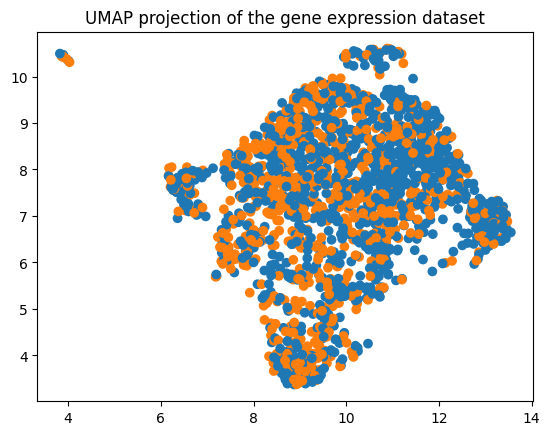

In [384]:
plt.scatter(
        visualization_dataset[:, 0],
        visualization_dataset[:, 1],
        c=[sns.color_palette()[x] for x in clinical_dataset['overall_survival'].values.astype(int) ]
)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the gene expression dataset')
plt.show()

In [385]:
reducer = umap.UMAP(n_components=20)
reducer.fit(gene_expr_dataset)
reduced = reducer.transform(gene_expr_dataset)
gene_expr_reduced = pd.DataFrame(reduced)
gene_expr_reduced.index = gene_expr_reduced.index

dataset['gene expression reduced']['X'] = gene_expr_reduced.to_numpy()

In [386]:
clf = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(dataset['gene expression reduced']['X'], dataset['gene expression reduced']['y'], test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
y_pred = np.round(clf.predict(X_test))
gene_expr_reduced_baseline_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of simple linear regression model on reduced gene expression data: {gene_expr_reduced_baseline_accuracy:.3f}')

Accuracy of simple linear regression model on reduced gene expression data: 0.625


In [387]:
reducer = umap.UMAP(n_components=10)
reducer.fit(dataset['clinical']['X'])
clinical_reduced = reducer.transform(dataset['clinical']['X'])

In [388]:
clf = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(clinical_reduced, dataset['clinical']['y'], test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
y_pred = np.round(clf.predict(X_test))
clinical_reduced_baseline_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of simple linear regression model on reduced clinical data: {clinical_reduced_baseline_accuracy:.3f}')

Accuracy of simple linear regression model on reduced clinical data: 0.749


<span style="color:orange">
    As we can see, applying dimension reduction on the clinical dataset leads to worse results, while on gene expression dataset improves the predictions.
    Therefore, we choose to reduce the dimensions of only the gene expression dataset. 
</span>



# Classic Model (25 Points)

In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)

In [389]:
# TODO

# Neural Network (30 Points)

In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)

In [390]:
# TODO

# Model Comparison (10 Points)

Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.

#### \# TODO